<a href="https://colab.research.google.com/github/deepme987/Tensorflow2-Object-Detection-API/blob/master/Masked_Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Jul 24 17:52:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# upload kaggle.json: Your account's API Key downloaded from kaggle

from google.colab import files
files.upload()

# Removed output to hide my API key

In [3]:
# Install kaggle and change permissions for the uploaded json file 

%%bash

pip install -q kaggle

mkdir -p ~/.kaggle
cp kaggle.json ~/.kaggle/
ls ~/.kaggle
chmod 600 /root/.kaggle/kaggle.json

rm kaggle.json

kaggle.json


In [ ]:
# Clone our github repository to access utility files for data preparation

%%bash

cd /content
git clone https://github.com/deepme987/Tensorflow2-Object-Detection-API
cd Tensorflow2-Object-Detection-API

# Replace the following line if you are working with different dataset from kaggle
kaggle datasets download -d andrewmvd/face-mask-detection
unzip face-mask-detection.zip

rm face-mask-detection.zip

In [ ]:
# Download Object Detection API and build necessary files

%%bash

cd /content

pip install -U --pre tensorflow_gpu=="2.2.0"

git clone --quiet https://github.com/tensorflow/models.git

cd /content/models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [34]:
# Update utility for EfficientDet model exporting, this will be fixed soon in the Object Detection Repository

!cp /content/Tensorflow2-Object-Detection-API/ed_fix.py /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/tf_utils.py

Overwriting /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/tf_utils.py


In [6]:
%cd /content/Tensorflow2-Object-Detection-API/

/content/Tensorflow2-Object-Detection-API


In [7]:
# The dataset contains all annotations in xml format. 
# However, we need csv files for Object Detection
# Change <PATH TO ANNOTATIONS> to point annotation directory and
# <OUTPUT FILE NAME> as required filename.csv for custom dataset

# !python xml_to_csv.py --xml_path=<PATH TO ANNOTATIONS> --csv_output=<OUTPUT FILE NAME>

!python xml_to_csv.py --xml_path=annotations/ --csv_output=annotations.csv

Reading xml from folder annotations/
Successfully converted xml to csv.


In [8]:
# Read all annotations from the generated csv

import pandas as pd

data = pd.read_csv("annotations.csv")
data

,filename,width,height,class,xmin,ymin,xmax,ymax
0,maksssksksss770.png,400,210,with_mask,45,43,51,53
1,maksssksksss770.png,400,210,with_mask,80,39,97,64
2,maksssksksss770.png,400,210,with_mask,156,57,176,75
3,maksssksksss770.png,400,210,with_mask,188,46,196,55
4,maksssksksss770.png,400,210,without_mask,215,38,227,53
...,...,...,...,...,...,...,...,...
4067,maksssksksss49.png,400,225,with_mask,20,54,41,72
4068,maksssksksss49.png,400,225,with_mask,123,68,141,87
4069,maksssksksss49.png,400,225,with_mask,157,45,173,63
4070,maksssksksss49.png,400,225,without_mask,95,211,113,225


In [9]:
# Split data into train-test
# Avoid using sklearn's train_test_split to split the data as it may use 
# same image in train as well as test for different annotation 

from sklearn.model_selection import GroupShuffleSplit

# You can change the test_size below (ideally between 0.2-0.4)
train_inds, test_inds = next(GroupShuffleSplit(test_size=0.30, random_state = 7).split(data, groups=data['filename']))

train = data.iloc[train_inds]
test = data.iloc[test_inds]


# Export the csv files, we'll use these for generating tfrecords
train.to_csv("train_labels.csv")
test.to_csv("test_labels.csv")

In [10]:
# Generate labelmap.pbtxt based on training labels.

ob = "{"
cb = "}"
nl = "\n"

string = ""
for i, class_ in enumerate(set(train["class"])):
    string += f"""
item {ob} 
  id: {i+1}
  name: '{class_}'
{cb}"""

with open("labelmap.pbtxt", 'w') as file:
    file.write(string)


In [11]:
# Check the labelmap file

!cat labelmap.pbtxt


item { 
  id: 1
  name: 'mask_weared_incorrect'
}
item { 
  id: 2
  name: 'without_mask'
}
item { 
  id: 3
  name: 'with_mask'
}

In [12]:
# Tensorflow uses tfrecord files for training
# To Generate tfrecord files based on input data (images and csv files).
# For huge datasets, this step may take long time 
# May take hours for dataset above 5GB

# Change the image path accordingly for your custom dataset
!python generate_tfrecord.py --csv_input train_labels.csv --output_path train.record --img_path="images/" --label_map labelmap.pbtxt
!python generate_tfrecord.py --csv_input test_labels.csv --output_path test.record --img_path="images/" --label_map labelmap.pbtxt

Successfully created the TFRecords: /content/Tensorflow2-Object-Detection-API/train.record
Successfully created the TFRecords: /content/Tensorflow2-Object-Detection-API/test.record


In [13]:
# Model vars

# Number of training steps.
num_steps = 5000

# Number of evaluation steps.
num_eval_steps = 100


# A batch size determines how many inputs the model will consider at once
# for training. Generally a higher batch size increases convergence of the model,
# but requires higher graphic memory.
# The batch sizes in the given list are for Google Colab (Tesla K80)
# You may increase or decrease them if you're running them locally.

# We are still testing batch sizes for other models.
# This list will be updated for other available models after testing them!

MODELS_CONFIG = {
    'efficientdet_d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'batch_size': 8
    },
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'efficientdet_d0'

# Load variables related to selection model
MODEL = MODELS_CONFIG[selected_model]['model_name']
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [14]:
# Initialize directory paths required 

DATASET_PATH = "/content/Tensorflow2-Object-Detection-API/"

# We save all the COCO downloaded models under fine_tune_models
!mkdir {DATASET_PATH}"fine_tune_models"

DEST_DIR = DATASET_PATH + "fine_tune_models/" + MODEL

# This is the directory where we will store our trained checkpoints
model_dir = DATASET_PATH + MODEL

!mkdir {model_dir}

In [16]:
# Your directory should look similar to this

!ls

annotations		       images		train_labels.csv
annotations.csv		       labelmap.pbtxt	train.record
efficientdet_d0_coco17_tpu-32  README.md	xml_to_csv.py
fine_tune_models	       test_labels.csv
generate_tfrecord.py	       test.record


Now that our data is prepared correctly, we can start with training our model.

In [17]:
import os

%cd /content/models/research

import shutil
import glob
import urllib.request
import tarfile

MODEL_FILE = MODEL + '.tar.gz'
# This is the base link for all the models pre-trained on COCO 2017
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'

# Download the weights for the pre-trained model
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# Delete the .zip file and move to fine_tune_models
os.remove(MODEL_FILE)
!mv {MODEL} {DEST_DIR}

/content/models/research


In [18]:
# Initializing other paths required for training

test_record_fname = DATASET_PATH + 'test.record'
train_record_fname = DATASET_PATH + 'train.record'
label_map_pbtxt_fname = DATASET_PATH + 'labelmap.pbtxt'
fine_tune_checkpoint = os.path.join(DEST_DIR, "checkpoint/ckpt-0")

In [19]:
# Tensorflow Object Detection API provides a list of sample configurations 
# that we can use by modifying the required paths and batch size

!cp "/content/models/research/object_detection/configs/tf2/"{pipeline_file} {model_dir}"/"{pipeline_file}
import os

pipeline_fname = os.path.join(model_dir, pipeline_file)

In [20]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [22]:
# Change the configuration based on our model and data

import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train2017)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val2017)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    #fine-tune checkpoint type
    s = re.sub('fine_tune_checkpoint_type: "classification"', 
               'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
    
    # s = re.sub('height: [0-9]+',
    #            'height: {}'.format(height), s)
    
    # s = re.sub('width: [0-9]+',
    #            'width: {}'.format(width), s)
    

    f.write(s)

In [23]:
# Confirm the changes made to the config
!cat {pipeline_fname}

 # SSD with EfficientNet-b0 + BiFPN feature extractor,
# shared box predictor and focal loss (a.k.a EfficientDet-d0).
# See EfficientDet, Tan et al, https://arxiv.org/abs/1911.09070
# See Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from an EfficientNet-b0 checkpoint.
#
# Train on TPU-8

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 3
    add_background_class: false
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      m

In [ ]:
# We then run Tensorboard to keep a track of our training process

%load_ext tensorboard
%tensorboard --logdir {model_dir}

In [ ]:
# Finally, we can start training our model

!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

In [26]:
# Check the files after training.
# A model creates checkpoints after some interval of time.

# Incase you stop training or run into any error, you can continue training 
# from the last available checkpoint. This can be to divide long training
# sessions into smaller batches

!ls {model_dir}

checkpoint		    ckpt-4.data-00001-of-00002
ckpt-1.data-00000-of-00002  ckpt-4.index
ckpt-1.data-00001-of-00002  ckpt-5.data-00000-of-00002
ckpt-1.index		    ckpt-5.data-00001-of-00002
ckpt-2.data-00000-of-00002  ckpt-5.index
ckpt-2.data-00001-of-00002  ckpt-6.data-00000-of-00002
ckpt-2.index		    ckpt-6.data-00001-of-00002
ckpt-3.data-00000-of-00002  ckpt-6.index
ckpt-3.data-00001-of-00002  ssd_efficientdet_d0_512x512_coco17_tpu-8.config
ckpt-3.index		    train
ckpt-4.data-00000-of-00002


In [ ]:
# Now that we trained our model, we can export the model's final checkpoint
# This will create a folder named "export" in the training directory which 
# contains the final checkpoint of the trained model

import re
import numpy as np

output_dir = model_dir + "/export"
!mkdir {output_dir}

!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir={model_dir} \
    --output_directory={output_dir} \
    --pipeline_config_path={pipeline_fname}

In [36]:
# Check the exported files
!ls {model_dir}"/export"

checkpoint  pipeline.config  saved_model


In [37]:
# Utility library and functions for testing the model

import matplotlib
import matplotlib.pyplot as plt
import os
import glob

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder


def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
        path: the file path to the image

    Returns:
        uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
            (im_height, im_width, 3)).astype(np.uint8)


def get_model_detection_function(model):
    """Get a tf.function for detection."""

    @tf.function
    def detect_fn(image):
        """Detect objects in image."""

        image, shapes = model.preprocess(image)
        prediction_dict = model.predict(image, shapes)
        detections = model.postprocess(prediction_dict, shapes)

        return detections, prediction_dict, tf.reshape(shapes, [-1])

    return detect_fn

In [38]:
# Load the configurations, initialize paths and resotore the export checkpoint

MODEL_TEST = model_dir + "/export/"

pipeline_config = MODEL_TEST + 'pipeline.config'
model_dir_test = MODEL_TEST + 'checkpoint/ckpt-0'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
            model_config=model_config, is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(
            model=detection_model)
ckpt.restore(os.path.join(model_dir_test))

In [39]:
# load labelmap, map them to it's labels and load the detector

detect_fn = get_model_detection_function(detection_model)

#map labels for inference decoding
label_map_path = label_map_pbtxt_fname
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
        label_map,
        max_num_classes=label_map_util.get_max_label_map_index(label_map),
        use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

/content/Tensorflow2-Object-Detection-API/images/maksssksksss389.png


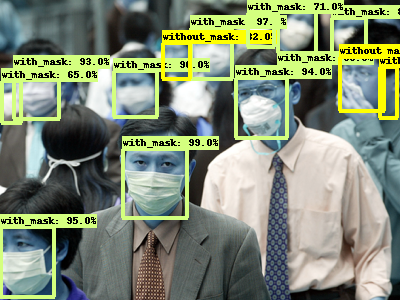

/content/Tensorflow2-Object-Detection-API/images/maksssksksss118.png


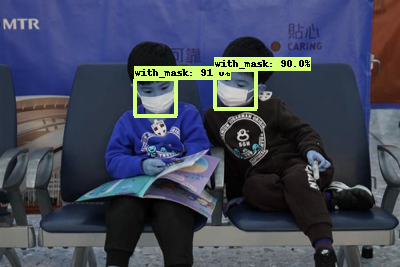

/content/Tensorflow2-Object-Detection-API/images/maksssksksss69.png


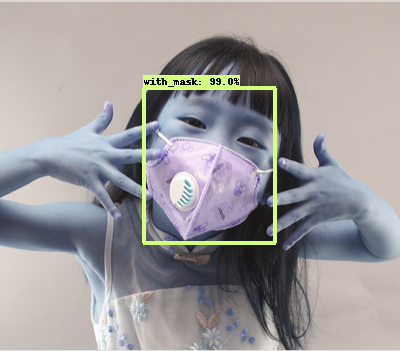

/content/Tensorflow2-Object-Detection-API/images/maksssksksss248.png


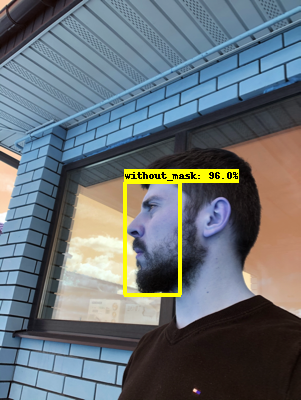

/content/Tensorflow2-Object-Detection-API/images/maksssksksss479.png


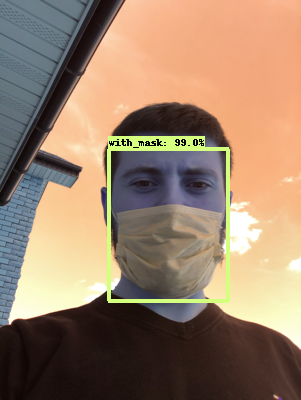

In [66]:
# Run the detector on image samples

import random
from google.colab.patches import cv2_imshow

# Images from this path will be considered for testing
# Change the extension accordingly if your dataset is not png
TEST_IMAGE_PATHS = glob.glob(DATASET_PATH + 'images/*.png')

# Change the value of k to the number of images to be considered for testing
try:
    images = random.sample(TEST_IMAGE_PATHS, k=5)
except:
  # Exception incase the value of k is higher than available samples
    images = TEST_IMAGE_PATHS


for image_path in images:
    print(image_path)
    image_np = load_image_into_numpy_array(image_path)
        
    input_tensor = tf.convert_to_tensor(
            np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'][0].numpy(),
                (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
                detections['detection_scores'][0].numpy(),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=200,
                min_score_thresh=.6,
                agnostic_mode=False,
    )


    cv2_imshow(image_np_with_detections)

In [40]:
# If you would like to test the model on your data, 
# create a folder named custom data and manually upload your files here

!mkdir {DATASET_PATH}custom_data
%cd {DATASET_PATH}custom_data

/content/Tensorflow2-Object-Detection-API/custom_data


In [ ]:
# Upload the images from your local files; you can upload multiple images at once

from google.colab import files
files.upload()

In [ ]:
# Same test cell from above, only image extension is changed


import random
from google.colab.patches import cv2_imshow

TEST_IMAGE_PATHS = glob.glob(DATASET_PATH + "custom_data/*.jpeg")

images = TEST_IMAGE_PATHS
for image_path in images:
    print(image_path)
    image_np = load_image_into_numpy_array(image_path)
        
    input_tensor = tf.convert_to_tensor(
            np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'][0].numpy(),
                (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
                detections['detection_scores'][0].numpy(),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=200,
                min_score_thresh=.6,
                agnostic_mode=False,
    )


    cv2_imshow(image_np_with_detections)

# Removed output to hide my model

In [46]:
# Download your trained model for future use or integration in other projects

!zip -r /content/model.zip {MODEL_TEST}

from google.colab import files
files.download("/content/model.zip")

  adding: content/Tensorflow2-Object-Detection-API/efficientdet_d0_coco17_tpu-32/export/ (stored 0%)
  adding: content/Tensorflow2-Object-Detection-API/efficientdet_d0_coco17_tpu-32/export/checkpoint/ (stored 0%)
  adding: content/Tensorflow2-Object-Detection-API/efficientdet_d0_coco17_tpu-32/export/checkpoint/ckpt-0.index (deflated 81%)
  adding: content/Tensorflow2-Object-Detection-API/efficientdet_d0_coco17_tpu-32/export/checkpoint/ckpt-0.data-00000-of-00002 (deflated 91%)
  adding: content/Tensorflow2-Object-Detection-API/efficientdet_d0_coco17_tpu-32/export/checkpoint/checkpoint (deflated 40%)
  adding: content/Tensorflow2-Object-Detection-API/efficientdet_d0_coco17_tpu-32/export/checkpoint/ckpt-0.data-00001-of-00002 (deflated 35%)
  adding: content/Tensorflow2-Object-Detection-API/efficientdet_d0_coco17_tpu-32/export/pipeline.config (deflated 69%)
  adding: content/Tensorflow2-Object-Detection-API/efficientdet_d0_coco17_tpu-32/export/saved_model/ (stored 0%)
  adding: content/Ten

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>